In [24]:
import os
# os.sys.path.append("C:\\Users\\markp\\repos\\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle
import itertools

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [29]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sess = [5,5,5,3,5,2,4,4,4,4,4,4]
rare = [i<5 for i in range(len(mice))]
freq = [(1-r)>0 for r in rare]
rare_mice = mice[:6]
freq_mice = mice[6:]
print(freq_mice)

['4222153.1', '4222153.2', '4222153.3', '4222174.1', '4222154.1', '4343702.1']


In [27]:
morphbin = np.linspace(-.11,1.11,num=11)
datadict = {}
for m,mouse in enumerate(mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    datadict[mouse]={}
    for ind in range(first_sess[m],df_mouse.shape[0]):
        print(ind)
        datadict[mouse][ind]={}
        sess = df_mouse.iloc[ind]
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        print(data.keys())
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0
        masks, SI,pvals = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        data['tstart_inds'], data['teleport_inds'],
                        win_trial_perm=True,morphlist=[0,.25,.5,.75,1],bootstrap=False,nperms=1000)
        
        morphs = trial_info['morphs']+trial_info['wallJitter']
        
        datadict[mouse][ind] = {'masks':masks,'S_trial_mat':S_trial_mat,'trial_info':trial_info,'pvals':pvals}

4139265.3
5


KeyboardInterrupt: 

In [39]:
print(datadict['4343706'].keys())
# datadict['4343706'].pop(8)
# datadict['4343706'].pop(6)
# datadict['4343706'].pop(2)
print(datadict['4343706'][3]['pvals'][0],datadict['4343706'][3]['masks'][0])

dict_keys([3, 4, 5, 7])
[0.085 0.979 0.    ... 0.275 0.011 0.884] [ True  True  True ... False  True False]


In [23]:
with open("D:\\Morph_Results\\PCResults.pkl","wb") as f:
    pickle.dump(datadict,f)
    

In [30]:
with open("D:\\Morph_Results\\PCResults.pkl","rb") as f:
    datadict = pickle.load(f)
    

(120, 45, 1498)


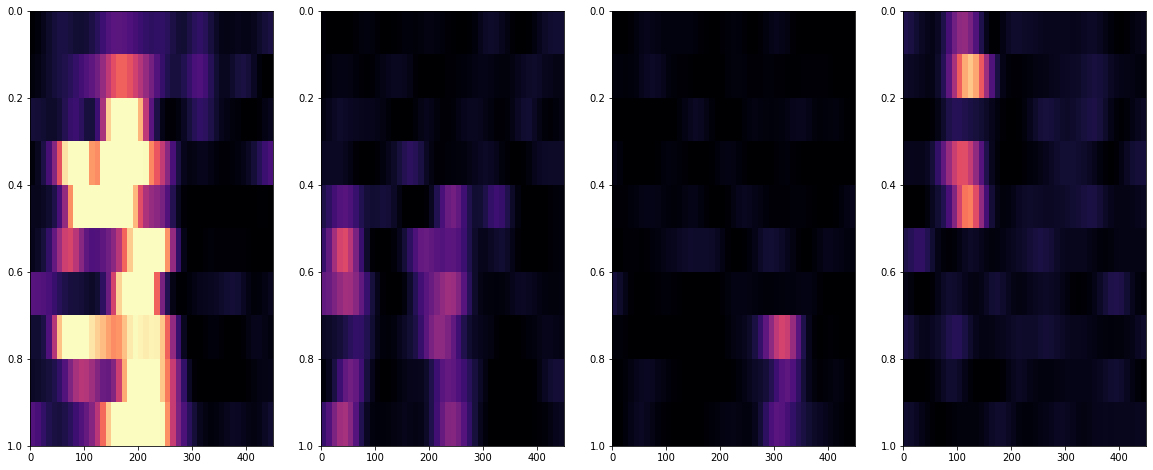

In [12]:
print(datadict['4139265.4'][9]['S_trial_mat'].shape)
morphbin = np.linspace(-.05,1.1,num=11)
morphs = datadict['4139265.4'][9]['trial_info']['morphs'] + datadict['4139265.4'][9]['trial_info']['wallJitter']
morphdig = np.digitize(morphs,morphbin)
S_tm_sig = sp.ndimage.filters.gaussian_filter1d(datadict['4139265.4'][9]['S_trial_mat'],2,axis=1)
S_tm_sig /=S_tm_sig.ravel().mean()
S_tm_bin = np.zeros([10,S_tm_sig.shape[1],S_tm_sig.shape[2]])
for i in range(10):
    if (morphdig==i).sum()>0:
        S_tm_bin[i,:,:] = S_tm_sig[morphdig==i,:,:].mean(axis=0)

f,ax = plt.subplots(1,4,figsize=[20,8])
for i,cell in enumerate([0,142,32,337]):
    ax[i].imshow(S_tm_bin[:,:,cell],aspect='auto',cmap='magma',extent=[0,450,1,0],vmin=.5,vmax=8)
f.savefig("D:\\Morph_Results\\figures\\exampleBinnedTrialMats.pdf")

(8358, 45)
(8358, 45)
(8358, 45)
(8358, 45)
(8358, 45)
(4116, 45)
(4116, 45)
(4116, 45)
(4116, 45)
(4116, 45)
(4483, 45)
(4483, 45)
(4483, 45)
(4483, 45)
(4483, 45)
(4882, 45)
(4882, 45)
(4882, 45)
(4882, 45)
(4882, 45)
(7658, 45)
(7658, 45)
(7658, 45)
(7658, 45)
(7658, 45)


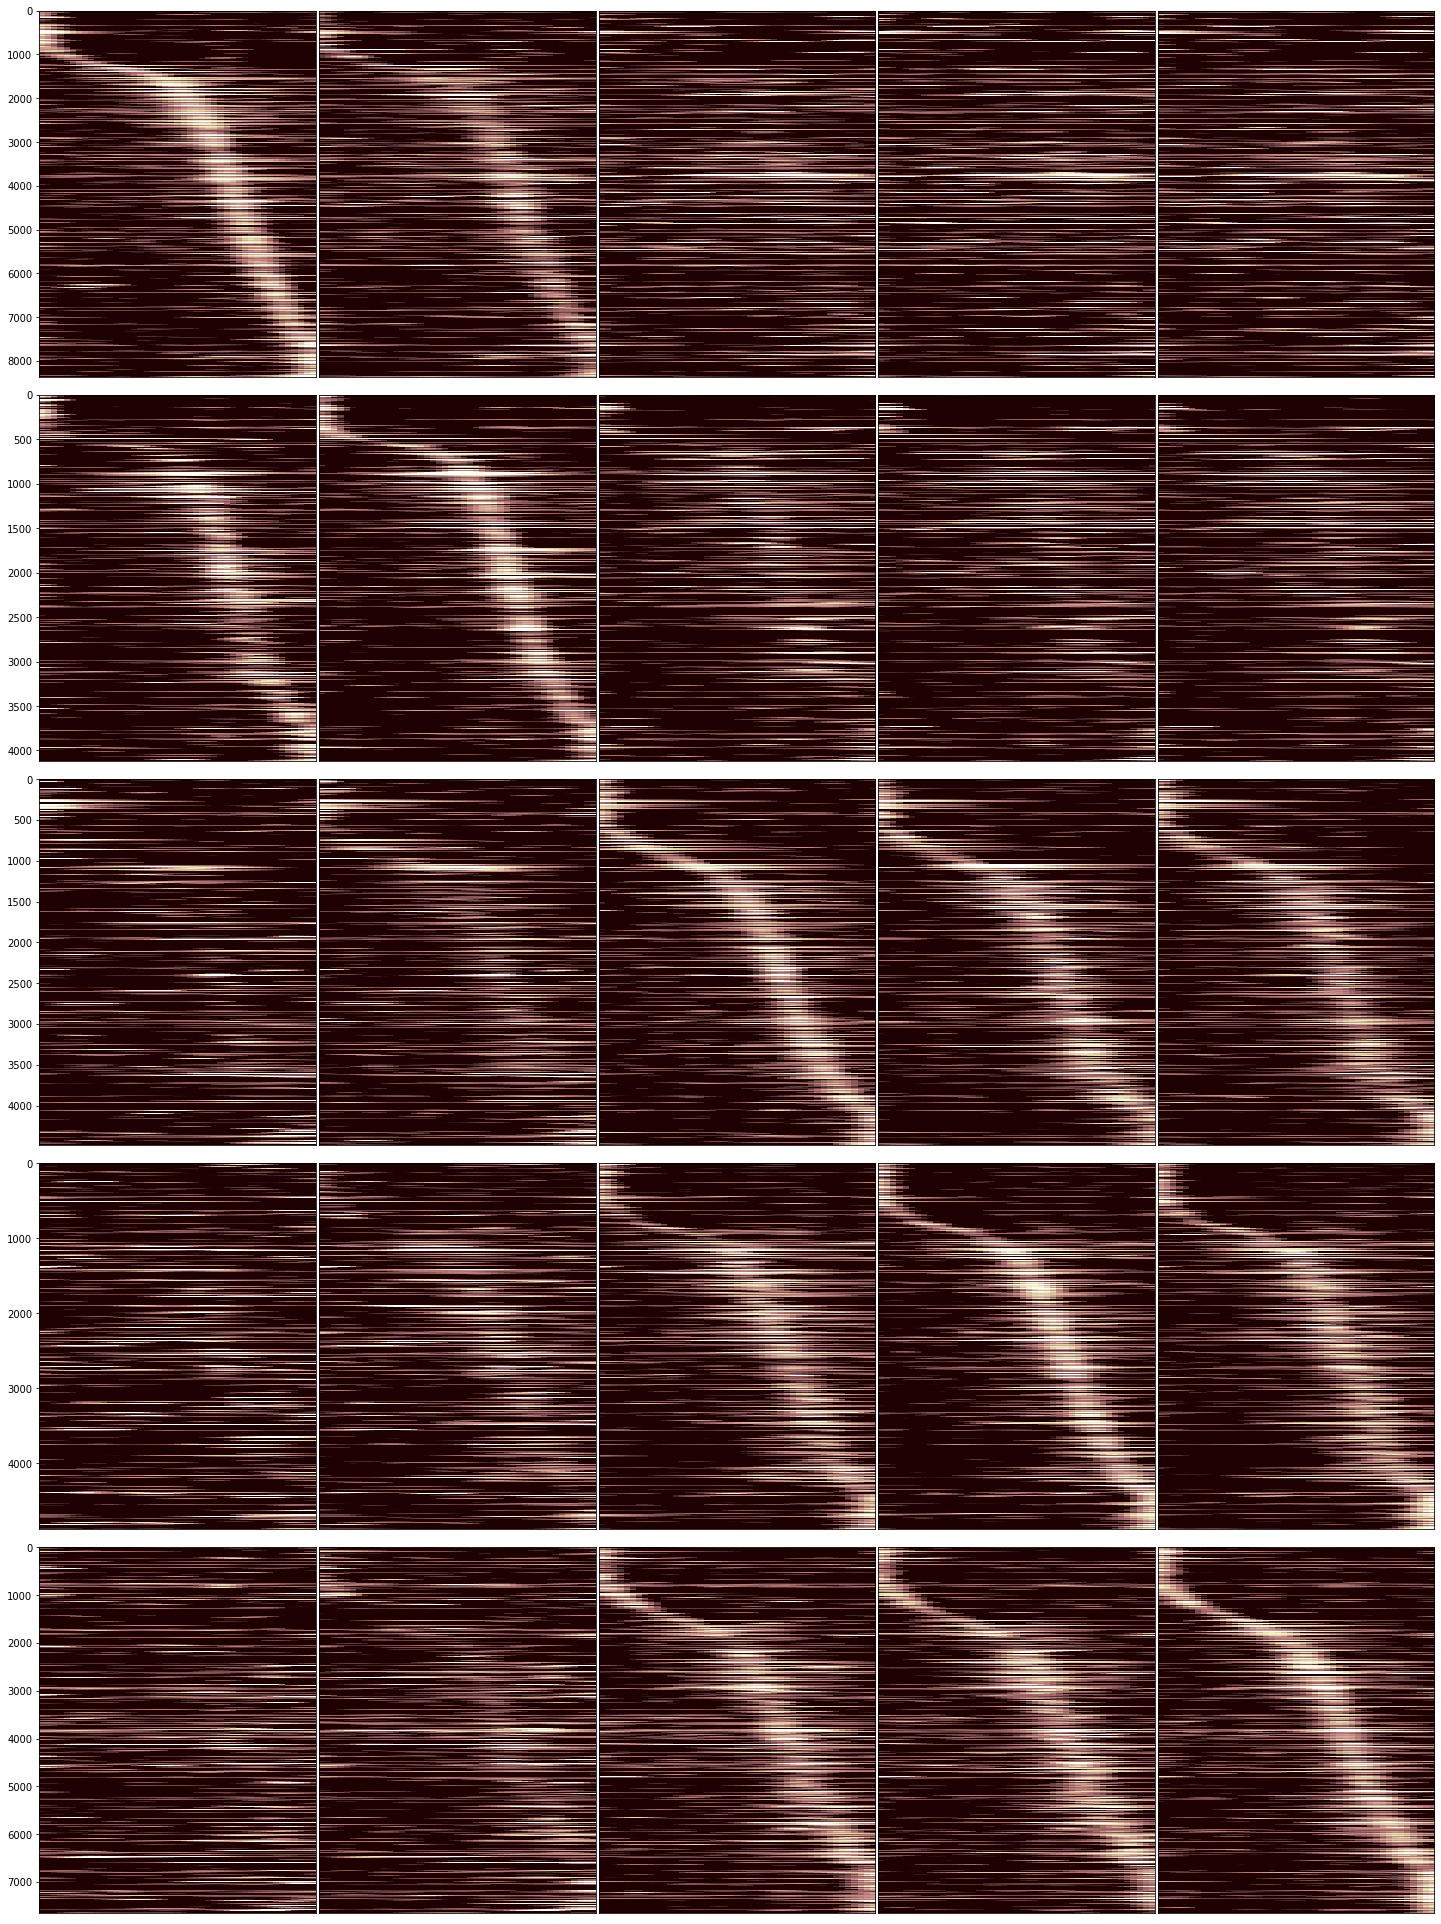

In [47]:
getSort = lambda fr : np.argsort(np.argmax(fr,axis=1))
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in rare_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
#         masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.png",format="png")

(3239, 45)
(3239, 45)
(3239, 45)
(3239, 45)
(3239, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2950, 45)
(2950, 45)
(2950, 45)
(2950, 45)
(2950, 45)


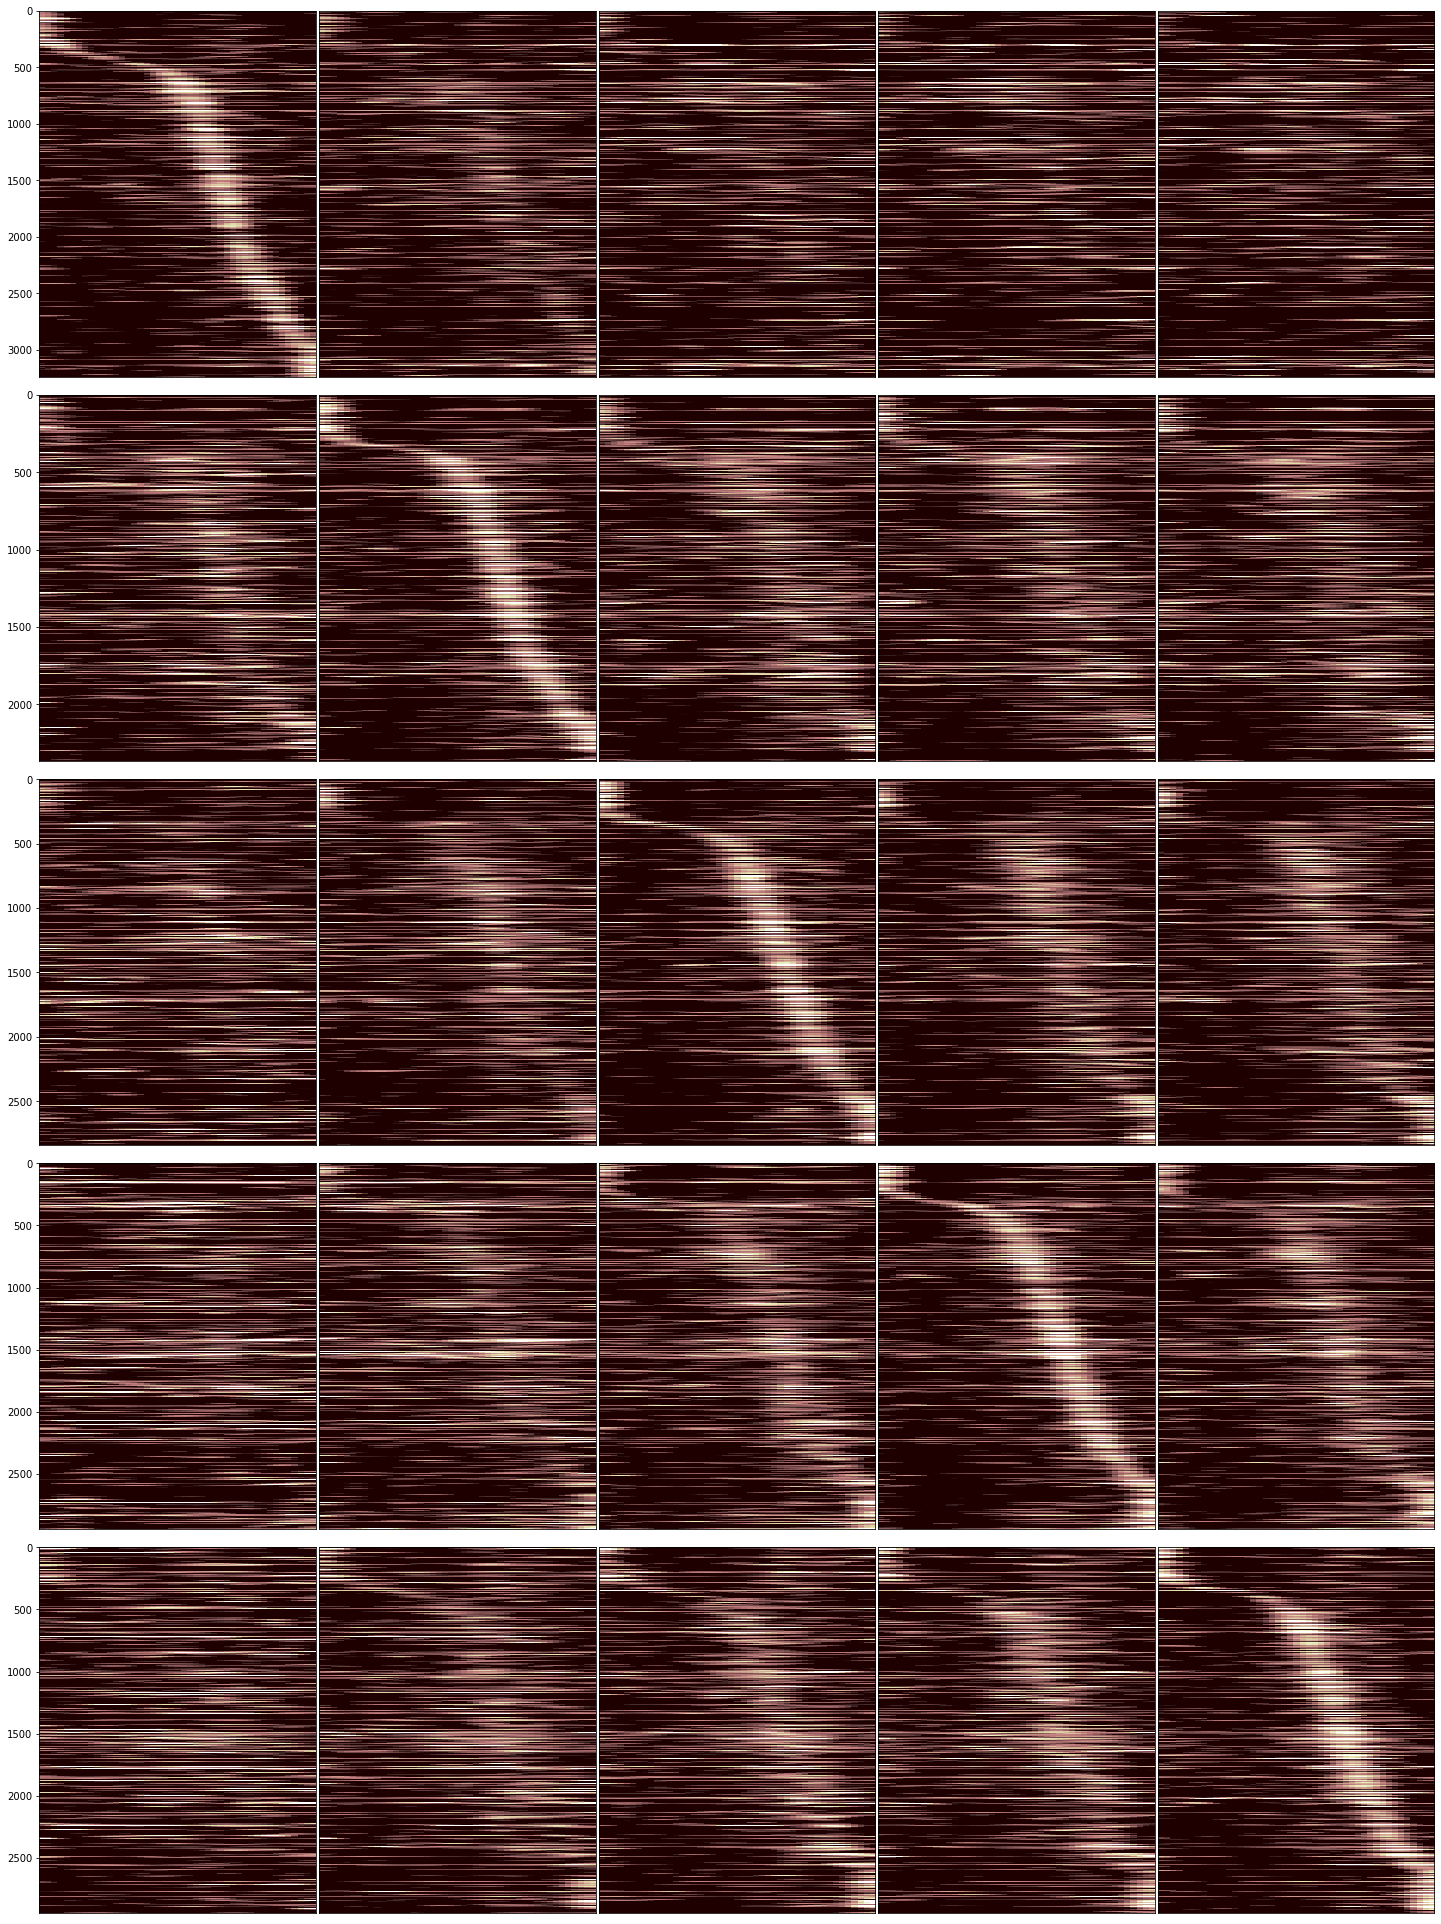

In [46]:
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in freq_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
#         masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\freq_all_placecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\frq_all_placecells.png",format="png")

In [48]:
mouselabel = []
rarefreqlabel = []
SM = []
sesslabel =[]
for mi, mouse in enumerate(mice):
    for si, (sess, sessdict) in enumerate(datadict[mouse].items()):
        # load data
        
        # OR mask
        for _i, (morph,mask) in enumerate(sessdict['masks'].items()):
            if _i == 0:
                ormask = mask
            else:
                ormask+=mask
        ormask = ormask>0
        
        # bin by morph value
        S_trial_mat = np.copy(sessdict['S_trial_mat'][:,:,ormask])
        S_binmat = np.zeros([5,*S_trial_mat.shape[1:]])
        for _i, m in enumerate(sessdict['masks'].keys()):
            S_binmat[_i,:,:] = S_trial_mat[sessdict['trial_info']['morphs']==m,:,:].mean(axis=0)
        S_binmat = S_binmat/np.linalg.norm(S_binmat,ord=2,axis=1,keepdims=True)
#         print(S_binmat.shape)
#         S_binmat = np.transpose(S_binmat, axes = (2,0,1))
        # similarity matrix 
        sm = np.matmul(np.transpose(S_binmat,axes=(2,0,1)),np.transpose(S_binmat,axes=(2,1,0)))
#         print(sm.shape)
        # save mouse and session index
        SM.append(sm)
        mouselabel.append(mi*np.ones((sm.shape[0],)))
        sesslabel.append(si*np.ones((sm.shape[0],)))
        if mi<5:
            rarefreqlabel.append(np.ones((sm.shape[0],)))
        else:
            rarefreqlabel.append(np.zeros((sm.shape[0],)))
    
SM = np.concatenate(SM,axis=0)
mouselabel = np.concatenate(mouselabel)
rarefreqlabel = np.concatenate(rarefreqlabel)
sesslabel = np.concatenate(sesslabel)

In [49]:
# for each permutation of mouse labels
diff_perms = []
iters =0
print(np.array(rare).sum())

for c, comb in enumerate(itertools.combinations(np.unique(mouselabel),6)):
    if c>0:
        rare_mask = np.zeros(mouselabel.shape)
        for _m_l  in comb:
#             print(_m_l)
            rare_mask += 1*(mouselabel==_m_l)
        rare_mask = rare_mask>0
#         print(SM.shape)
        diff_perms.append(SM[rare_mask,:,:].mean(axis=0)-SM[~rare_mask,:,:].mean(axis=0))
print(c)
diff_perms = np.array(diff_perms)
print(diff_perms.shape)
diff_min,diff_max = np.percentile(diff_perms,2.5,axis=0),np.percentile(diff_perms,97.5,axis=0)
print(diff_min)
print(diff_max)

5
923
(923, 5, 5)
[[ 0.         -0.06809275 -0.06976803 -0.07109184 -0.06290867]
 [-0.06809275  0.         -0.09704835 -0.09797109 -0.09164482]
 [-0.06976803 -0.09704835  0.         -0.07580796 -0.07692016]
 [-0.07109184 -0.09797109 -0.07580796  0.         -0.07537937]
 [-0.06290867 -0.09164482 -0.07692016 -0.07537937  0.        ]]
[[0.         0.06757215 0.06976803 0.07109184 0.06290867]
 [0.06757215 0.         0.09704835 0.09797109 0.09164482]
 [0.06976803 0.09704835 0.         0.07580796 0.07692016]
 [0.07109184 0.09797109 0.07580796 0.         0.07537937]
 [0.06290867 0.09164482 0.07692016 0.07537937 0.        ]]


[[ 0.         -0.00468631  0.0836453   0.0849984   0.06330234]
 [-0.00468631  0.          0.11287489  0.11714787  0.09484037]
 [ 0.0836453   0.11287489  0.          0.03597632  0.01033619]
 [ 0.0849984   0.11714787  0.03597632  0.          0.00881473]
 [ 0.06330234  0.09484037  0.01033619  0.00881473  0.        ]]


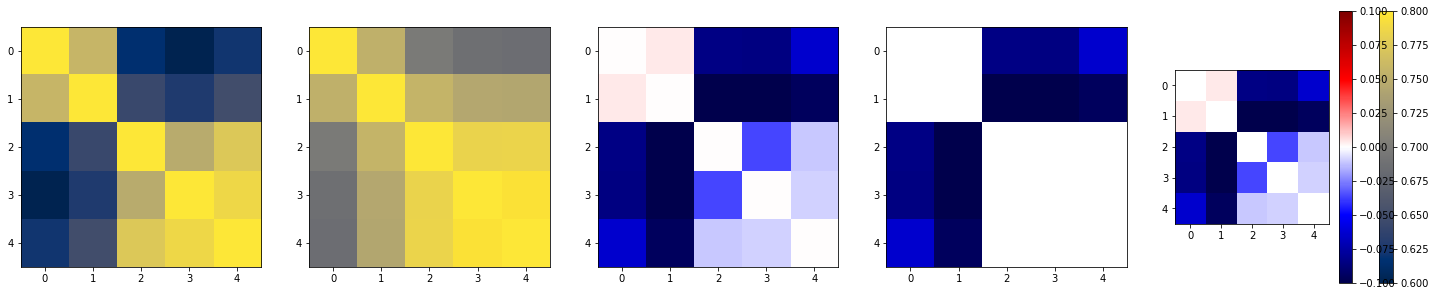

In [62]:
f,ax = plt.subplots(1,5,figsize= [25,5])
muf,mur = SM[rarefreqlabel==0,:,:].mean(axis=0),SM[rarefreqlabel==1,:,:].mean(axis=0)
diff = muf-mur
im=ax[0].imshow(mur,cmap='cividis',vmin=.6,vmax=.8)
f.colorbar(im)
ax[1].imshow(muf,cmap='cividis',vmin=.6,vmax=.8)
ax[2].imshow(-diff,cmap='seismic',vmin=-.1,vmax=.1)
print(diff)
mask = ((diff>diff_max) + (diff<diff_min))>0
diff[~mask]=np.nan
ax[3].imshow(-diff,cmap='seismic',vmin=-.1,vmax=.1)

t,p = sp.stats.ttest_ind(SM[rarefreqlabel==0,:],SM[rarefreqlabel==1,:],axis=0)
mask = p<.005
diff = muf-mur
diff[~mask]=np.nan
im = ax[4].imshow(-diff,cmap='seismic',vmin=-.1,vmax=.1)
f.colorbar(im)

f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.png",format="png")

In [67]:
print(SM.shape)

(1795, 5)


In [11]:
print(SI[0]['all'].shape)

(2746,)


In [4]:
# loop through mice

In [60]:
# numbers for main text

num = 0
den = 0
orcount = 0
andcount = 0 
count0,count1 = 0,0
for mouse in rare_mice: 
    print(mouse)
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
        allmask = masks[0]
        
        orcount += (masks[0]|masks[1]).sum()
        andcount += (masks[0]&masks[1]).sum()
        count0+= masks[0].sum()
        count1+=masks[1].sum()
        print(allmask.shape)
        for k,mask in masks.items():
            allmask = allmask|mask
        
        num += allmask.sum()
        den += allmask.shape[0]
print("Total number of place cells: %f" % num,"Pecent: %f" % (num/den))
print("0 pcnt %f" % (count0/den),"1 pcnt %f" % (count1/den),"random ovlp %f" % (count0/den*count1/den),"actual ovlp %f" %(andcount/den))
print("0 pcnt %f" % (count0/num),"1 pcnt %f" % (count1/num),"random ovlp %f" % (count0/num*count1/num),"actual ovlp %f" %(andcount/num))

4139265.3
(1828,)
(1904,)
(1817,)
(1708,)
(1715,)
4139265.4
(1632,)
(1656,)
(1515,)
(1650,)
(1498,)
(1631,)
4139265.5
(915,)
(976,)
(984,)
(932,)
(1047,)
4222168.1
(919,)
(1035,)
(1074,)
(940,)
4343703.1
(1194,)
4343706
(2336,)
(2652,)
(1403,)
(1617,)
Total number of place cells: 15829.000000 Pecent: 0.432746
0 pcnt 0.228498 1 pcnt 0.209361 random ovlp 0.047839 actual ovlp 0.060665
0 pcnt 0.528018 1 pcnt 0.483796 random ovlp 0.255453 actual ovlp 0.140186


In [58]:
# numbers for main text

num = 0
den = 0
orcount = 0
andcount = 0 
count0,count1 = 0,0
for mouse in freq_mice: 
    print(mouse)
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
        allmask = masks[0]
        
        orcount += (masks[0]|masks[1]).sum()
        andcount += (masks[0]&masks[1]).sum()
        count0+= masks[0].sum()
        count1+=masks[1].sum()
        print(allmask.shape)
        for k,mask in masks.items():
            allmask = allmask|mask
        
        num += allmask.sum()
        den += allmask.shape[0]
print("Total number of place cells: %f" % num,"Pecent: %f" % (num/den))
print("0 pcnt %f" % (count0/den),"1 pcnt %f" % (count1/den),"random ovlp %f" % (count0/den*count1/den),"actual ovlp %f" %(andcount/den))

4222153.1
(301,)
(273,)
(237,)
4222153.2
(2127,)
(2149,)
(2046,)
(2006,)
4222153.3
(161,)
4222174.1
(1963,)
(1998,)
(2047,)
(2117,)
(1901,)
4222154.1
(309,)
(571,)
(326,)
(311,)
(257,)
4343702.1
(3313,)
(2875,)
(2746,)
Total number of place cells: 8933.000000 Pecent: 0.297430
0 pcnt 0.107844 1 pcnt 0.098222 random ovlp 0.010593 actual ovlp 0.019778
